<a href="https://colab.research.google.com/github/MariamMedhat-gif/Major-Task_Machine-Vision/blob/main/Milestone1_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Libraries**

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage import exposure
import cv2
from sklearn.metrics import accuracy_score, classification_report

**Data loading**

In [ ]:
dataset, info = tfds.load('caltech101', with_info=True, as_supervised=True)

# The dataset is divided into training and test splits.
train_dataset_original_hog = dataset['train']
test_dataset_original_hog = dataset['test']

train_dataset_original_lbp = dataset['train']
test_dataset_original_lbp = dataset['test']

train_dataset_original_color = dataset['train']
test_dataset_original_color = dataset['test']
print("DONE!")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3060 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/incomplete.DP9H7A_3.0.2/caltech101-train.tfrecord*...:   0%|   …

Generating test examples...:   0%|          | 0/6084 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/incomplete.DP9H7A_3.0.2/caltech101-test.tfrecord*...:   0%|    …

Dataset caltech101 downloaded and prepared to /root/tensorflow_datasets/caltech101/3.0.2. Subsequent calls will reuse this data.
DONE!


Process data

In [ ]:
IMG_SIZE_HOG = (128, 128)

def preprocess_image_hog(image, label):
    """
    Resize and normalize the image.
    Args:
        image: The input image.
        label: The label corresponding to the image.
    Returns:
        Resized and normalized image, label.
    """
    # Resize the image
    image = tf.image.resize(image, IMG_SIZE_HOG)
    # Normalize the image to the range [0, 1]
    image = image / 255.0
    return image, label

IMG_SIZE_LBP=(256,256)
def preprocess_image_LBP(image, label):
    """
    Resize and normalize the image.
    Args:
        image: The input image.
        label: The label corresponding to the image.
    Returns:
        Resized and normalized image, label.
    """
    # Resize the image
    image = tf.image.resize(image, IMG_SIZE_LBP)
    # Normalize the image to the range [0, 1]
    image = image / 255.0
    return image, label

train_dataset_original_hog = train_dataset_original_hog.map(preprocess_image_hog).batch(32).shuffle(1000)
test_dataset_original_hog = test_dataset_original_hog.map(preprocess_image_hog).batch(32)



Visulaize Data

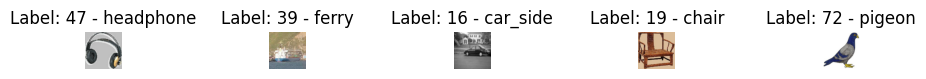

In [ ]:
class_names = info.features['label'].names

def visualize_data(dataset, num_samples=5):
    """
    Visualizes the first few images from the dataset.
    Args:
        dataset: The TensorFlow dataset.
        num_samples: Number of samples to display.
    """
    plt.figure(figsize=(10, 5))
    for i, (image, label) in enumerate(dataset.take(num_samples)):
        class_name = class_names[label.numpy()]
        plt.subplot(1, num_samples, i + 1)# 1 row 5 coulmns where to put image
        plt.imshow(image)
        plt.title(f"Label: {label.numpy()} - {class_name}")
        plt.axis("off")
    plt.subplots_adjust(wspace=4)  # Increase the space between images
    plt.show()

# Visualize first 5 samples from the training set
for images, labels in train_dataset_original_hog.take(1):
    visualize_data(tf.data.Dataset.from_tensor_slices((images, labels)))

HOG

In [ ]:
def extract_hog_features(dataset):
    hog_features = []
    labels = []

    # Iterate through the dataset (Note: dataset is batched)
    for images, batch_labels in dataset:
        # Convert the TensorFlow tensor to a NumPy array
        images_np = images.numpy()

        # Loop over each image in the batch and compute HOG features
        for img_np, label in zip(images_np, batch_labels.numpy()):
            # Convert the image to grayscale
            gray_img = rgb2gray(img_np)

            # Compute HOG features
            features = hog(gray_img,
                           pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2),
                           block_norm='L1',
                           visualize=False)

            # Append the features and labels to the lists
            hog_features.append(features)
            labels.append(label)

    # Return the extracted features and labels as NumPy arrays
    return np.array(hog_features), np.array(labels)

def standardize_data(train_features, test_features):
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)
    test_features = scaler.transform(test_features)
    return train_features, test_features

def apply_pca(train_features, test_features, n_components=50):
    pca = PCA(n_components=n_components)
    train_features_pca = pca.fit_transform(train_features)
    test_features_pca = pca.transform(test_features)
    return train_features_pca, test_features_pca

# Extract HOG features for training and testing datasets

train_hog_features, train_labels_hog_features = extract_hog_features(train_dataset_original_hog)
test_hog_features, test_labels_hog_features = extract_hog_features(test_dataset_original_hog)

# Standardize the features
train_hog_features, test_hog_features = standardize_data(train_hog_features, test_hog_features)

# Apply PCA for dimensionality reduction
train_hog_features_pca, test_hog_features_pca = apply_pca(train_hog_features, test_hog_features, n_components=50)

# Train-test split for cross-validation
X_train_spilted_hog, X_valid_splited_hog, y_train_splited_hog, y_valid_splited_hog = train_test_split(
    train_hog_features_pca, train_labels_hog_features, test_size=0.2, random_state=42 #same randomization each run
)

# Verify the shape of HOG features
print(f"Train HOG features shape: {train_hog_features.shape}")
print(f"Test HOG features shape: {test_hog_features.shape}")

X_train_spilted_hog_p1 = np.copy(X_train_spilted_hog)
X_valid_splited_hog_p1 = np.copy(X_valid_splited_hog)
y_train_splited_hog_p1 = np.copy(y_train_splited_hog)
y_valid_splited_hog_p1 = np.copy(y_valid_splited_hog)

X_train_spilted_hog_p2 = np.copy(X_train_spilted_hog)
X_valid_splited_hog_p2 = np.copy(X_valid_splited_hog)
y_train_splited_hog_p2 = np.copy(y_train_splited_hog)
y_valid_splited_hog_p2 = np.copy(y_valid_splited_hog)


Train HOG features shape: (3060, 8100)
Test HOG features shape: (6084, 8100)


Local Binary

In [ ]:
def extract_lbp_features(image, radius=1, n_points=8):
    """
    Extract Local Binary Pattern (LBP) features from an image.
    Args:
        image: Input image (H, W, C).
        radius: Radius of the LBP pattern.
        n_points: Number of points in the LBP pattern.
    Returns:
        A flattened LBP histogram.
    """
    # Convert image to grayscale
    gray_image = tf.image.rgb_to_grayscale(image).numpy().squeeze()

    # Compute the LBP
    lbp = local_binary_pattern(gray_image, n_points, radius, method="uniform")

    # Compute histogram
    hist, _ = np.histogram(
        lbp.ravel(),
        bins=np.arange(0, n_points + 3),  # Uniform LBP bins
        range=(0, n_points + 2),
    )
    hist = hist.astype("float")
    hist /= hist.sum()  # Normalize the histogram
    return hist

def preprocess_dataset(dataset):
    """
    Extract LBP features and labels from the dataset.
    """
    X = []
    y = []
    for image, label in dataset.unbatch():
        #lbp_features=extract_lbp_features(image, radius=2, n_points=16)
        hist1 = extract_lbp_features(image, radius=1, n_points=8)
        hist2 = extract_lbp_features(image, radius=2, n_points=16)
        hist3 = extract_lbp_features(image, radius=3, n_points=24)
        hist4 = extract_lbp_features(image, radius=4, n_points=48)
        hist5 = extract_lbp_features(image, radius=5, n_points=96)
        lbp_features = np.concatenate([hist1, hist2, hist3,hist4,hist5])
        X.append(lbp_features)
        y.append(label.numpy())
    # Plot the concatenated histogram
    return np.array(X), np.array(y)

# Extract features
train_dataset_original_lbp = train_dataset_original_lbp.map(preprocess_image_LBP).batch(32).shuffle(1000)
test_dataset_original_lbp = test_dataset_original_lbp.map(preprocess_image_LBP).batch(32)

train_features_LBP, train_labels_LBP = preprocess_dataset(train_dataset_original_lbp)
test_features_LBP, test_labels_LBP = preprocess_dataset(test_dataset_original_lbp)

# Standardize the features
train_features_LBP, test_features_LBP = standardize_data(train_features_LBP, test_features_LBP)

# Apply PCA for dimensionality reduction
#train_features_LBP_pca, test_features_LBP_pca = apply_pca(train_features_LBP, test_features_LBP, n_components=50)

# Train-test split for cross-validation
X_train_spilted_LBP, X_valid_splited_LBP, y_train_splited_LBP, y_valid_splited_LBP = train_test_split(
    train_features_LBP, train_labels_LBP, test_size=0.2, random_state=42
)
print(f"Train LBP features shape: {train_features_LBP.shape}")
print(f"Test LBP features shape: {test_features_LBP.shape}")

X_train_spilted_LBP_p1 = np.copy(X_train_spilted_LBP)
X_valid_splited_LBP_p1 = np.copy(X_valid_splited_LBP)
y_train_splited_LBP_p1 = np.copy(y_train_splited_LBP)
y_valid_splited_LBP_p1 = np.copy(y_valid_splited_LBP)

/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Train LBP features shape: (3060, 202)
Test LBP features shape: (6084, 202)


Color Histogram

In [ ]:
IMG_SIZE_COLOR_HIST = (256, 256)

def preprocess_image_color_hist(image, label):
    """
    Resize the image and convert it to HSV for color histogram extraction.
    Args:
        image: The input image.
        label: The label corresponding to the image.
    Returns:
        Resized HSV image, label.
    """
    # Resize the image
    image = tf.image.resize(image, IMG_SIZE_COLOR_HIST)

    # Convert the image to HSV color space
    image_hsv = tf.image.rgb_to_hsv(image)

    return image_hsv, label

def extract_color_histogram(image, bins=32):
    """
    Extract a color histogram from an image.
    Args:
        image: Input image (H, W, C) in RGB format.
        bins: Number of bins for the histogram.
    Returns:
        A concatenated histogram for R, G, and B channels.
    """
    # Convert the TensorFlow tensor to a NumPy array
    image_np = image.numpy()

    # Compute histograms for each channel (R, G, B)
    hist_r, _ = np.histogram(image_np[:, :, 0], bins=bins, range=(0, 255))
    hist_g, _ = np.histogram(image_np[:, :, 1], bins=bins, range=(0, 255))
    hist_b, _ = np.histogram(image_np[:, :, 2], bins=bins, range=(0, 255))

    # Normalize histograms
    hist_r = hist_r / hist_r.sum()
    hist_g = hist_g / hist_g.sum()
    hist_b = hist_b / hist_b.sum()

    # Concatenate histograms into a single feature vector
    color_histogram = np.concatenate([hist_r, hist_g, hist_b])
    return color_histogram

def extract_color_histogram_with_spatial(image, bins=128, grid_size=8):
    """
    Extract color histograms from spatially partitioned regions of an image.
    Args:
        image: Input image (H, W, C).
        bins: Number of bins for the histogram.
        grid_size: Number of divisions along each axis (e.g., 4x4 grid).
    Returns:
        Concatenated histograms from all grid regions.
    """
    h, w, c = image.shape
    grid_h, grid_w = h // grid_size, w // grid_size
    histograms = []
    for i in range(grid_size):
        for j in range(grid_size):
            # Extract region
            region = image[i * grid_h:(i + 1) * grid_h, j * grid_w:(j + 1) * grid_w]
            # Extract histogram for the region
            histograms.append(extract_color_histogram(region, bins))
    return np.concatenate(histograms)

def preprocess_dataset_with_color(dataset, bins=32):
    """
    Extract color histogram features and labels from the dataset.
    Args:
        dataset: The input TensorFlow dataset.
        bins: Number of bins for the color histogram.
    Returns:
        Feature matrix (X) and labels (y).
    """
    X = []
    y = []

    for element in dataset:
        # If the dataset contains (image, label) tuples
        if isinstance(element, tuple):
            image, label = element
        else:
            # Adjust if the dataset format is scalar or needs unpacking differently
            raise ValueError("Unexpected dataset structure: ensure it's in (image, label) format.")

        # Extract color histogram features
        color_histogram = extract_color_histogram_with_spatial(image, bins=128)

        # Combine feature
        X.append(color_histogram)
        y.append(label.numpy())

    return np.array(X), np.array(y)

train_dataset_original_color = train_dataset_original_color.map(preprocess_image_color_hist).batch(32).shuffle(1000).unbatch()
test_dataset_original_color = test_dataset_original_color.map(preprocess_image_color_hist).batch(32).unbatch()

# Extract color histogram features
train_features_color, train_labels_color = preprocess_dataset_with_color(train_dataset_original_color, bins=128)
test_features_color, test_labels_color = preprocess_dataset_with_color(test_dataset_original_color, bins=128)


# Standardize the features
train_features_color, test_features_color = standardize_data(train_features_color, test_features_color)

# Apply PCA for dimensionality reduction
train_features_color_pca, test_features_color_pca = apply_pca(train_features_color, test_features_color, n_components=100)

# Train-test split for cross-validation
X_train_split_color, X_valid_split_color, y_train_split_color, y_valid_split_color = train_test_split(
    train_features_color_pca, train_labels_color, test_size=0.2, random_state=42
)

print(f"Train Color Histogram features shape: {train_features_color.shape}")
print(f"Test Color Histogram features shape: {test_features_color.shape}")

# Example: Split the training data for validation
X_train_spilted_color_p1 = np.copy(X_train_split_color)
X_valid_splited_color_p1 = np.copy(X_valid_split_color)
y_train_splited_color_p1 = np.copy(y_train_split_color)
y_valid_splited_color_p1 = np.copy(y_valid_split_color)

Train Color Histogram features shape: (3060, 24576)
Test Color Histogram features shape: (6084, 24576)


KNN (Euclidean Distance Measurement)

In [ ]:
def euclidean_distance(x1, x2):
    """
    Compute the Euclidean distance between vectors.
    Args:
        x1: Single vector or multiple vectors (1D or 2D).
        x2: Single vector (1D).
    Returns:
        Distance(s) as a scalar or array.
    """
    x1 = np.array(x1)
    x2 = np.array(x2)
    return np.sqrt(np.sum((x1 - x2) ** 2, axis=-1))  # Handles 1D and 2D

def knn_predict(train_data, train_labels, test_data, k):
    """
    Predict the label for a test data point using the k-nearest neighbors algorithm.

    Args:
    - train_data (np.ndarray): Training feature vectors.
    - train_labels (list or np.ndarray): Corresponding labels for the training data.
    - test_data (np.ndarray): A single test feature vector.
    - k (int): Number of neighbors to consider.

    Returns:
    - predicted_label: The label predicted for the test data.
    """
    # Compute distances and pair each with the corresponding label
    distances_and_labels = [
        (euclidean_distance(test_data, x_train), train_labels[i])
        for i, x_train in enumerate(train_data)
    ]

    # Sort pairs by distance
    sorted_neighbors = sorted(distances_and_labels, key=lambda x: x[0])

    # Extract the labels of the k nearest neighbors
    k_labels = [label for _, label in sorted_neighbors[:k]]

    # Majority vote to determine the predicted label
    predicted_label = Counter(k_labels).most_common(1)[0][0]

    return predicted_label

Kmeans

In [ ]:
def K_Means_fit(X,k=3, max_iterations=200):
    global centroids
    centroids=np.random.uniform(np.amin(X,axis=0),np.amax(X,axis=0) ,size=(k,X.shape[1]))
    for _ in range(max_iterations):
        y=[]
        for data_point in X:
            distances=euclidean_distance(data_point,centroids)
            cluster_num=np.argmin(distances)
            y.append(cluster_num)
        y=np.array(y)
        cluster_index=[]

        for i in range(k):
            cluster_index.append(np.argwhere(y==i))

        cluster_centers=[]

        for i,index in enumerate(cluster_index):
            if len(index)==0:
                cluster_centers.append(centroids[i])
            else:
                cluster_centers.append(np.mean(X[index],axis=0)[0])

        if np.max(centroids-np.array(cluster_centers))<0.001:
            break
        else:
            centroids=np.array(cluster_centers)
    return y

def map_clusters_to_labels(y_true, y_clusters, k):
    cluster_to_label = {}

    # For each cluster, find the most common label in that cluster
    for cluster in range(k):
        cluster_indices = np.where(y_clusters == cluster)[0]

        # Check if the cluster has data points
        if len(cluster_indices) > 0:
            cluster_labels = y_true[cluster_indices]

            # Majority voting to assign the most common label to the cluster
            most_common_label = np.bincount(cluster_labels).argmax()
            cluster_to_label[cluster] = most_common_label
        else:
            # If the cluster is empty, you can assign a default label (e.g., -1 or any label of your choice)
            cluster_to_label[cluster] = -1  # Or choose any default label

    # Map predicted clusters to actual labels
    y_pred_mapped = np.array([cluster_to_label.get(cluster, -1) for cluster in y_clusters])
    return y_pred_mapped

# Fit the K-Means model to the training data (using HOG features)
k = 102  # Number of clusters for Caltech101 dataset (102 classes)
print("HOG RESULTS")
y_train_clusters = K_Means_fit(X_train_spilted_hog_p2, k=k, max_iterations=2000)

y_train_pred = map_clusters_to_labels(y_train_splited_hog_p2, y_train_clusters, k)

# Calculate accuracy
train_accuracy = accuracy_score(y_train_splited_hog_p2, y_train_pred)
print(f'Clustering accuracy on training set: {train_accuracy * 100:.2f}%')
# Predict clusters for the validation set using the centroids obtained from training
y_valid_clusters = K_Means_fit(X_valid_splited_hog_p2, k=k, max_iterations=200000)

# Map clusters to labels for the validation set
y_valid_pred = map_clusters_to_labels(y_valid_splited_hog_p2, y_valid_clusters, k)

# Calculate accuracy for the validation set
valid_accuracy = accuracy_score(y_valid_splited_hog_p2, y_valid_pred)
print(f'Clustering accuracy on validation set: {valid_accuracy * 100:.2f}%')
###################################################################################
print("LBP RESULTS")
y_train_clusters = K_Means_fit(X_train_spilted_LBP, k=k, max_iterations=2000)
y_train_pred = map_clusters_to_labels(y_train_splited_LBP, y_train_clusters, k)

# Calculate accuracy
train_accuracy = accuracy_score(y_train_splited_LBP, y_train_pred)
print(f'Clustering accuracy on training set: {train_accuracy * 100:.2f}%')

# Predict clusters for the validation set using the centroids obtained from training
y_valid_clusters = K_Means_fit(X_valid_splited_LBP, k=k, max_iterations=200000)

# Map clusters to labels for the validation set
y_valid_pred = map_clusters_to_labels(y_valid_splited_LBP, y_valid_clusters, k)

# Calculate accuracy for the validation set
valid_accuracy = accuracy_score(y_valid_splited_LBP, y_valid_pred)
print(f'Clustering accuracy on validation set: {valid_accuracy * 100:.2f}%')
######################################################################################
print("COLOR RESULTS")
y_train_clusters = K_Means_fit(X_train_spilted_color_p1, k=k, max_iterations=2000)
y_train_pred = map_clusters_to_labels(y_train_splited_color_p1, y_train_clusters, k)

# Calculate accuracy
train_accuracy = accuracy_score(y_train_splited_color_p1, y_train_pred)
print(f'Clustering accuracy on training set: {train_accuracy * 100:.2f}%')
# Predict clusters for the validation set using the centroids obtained from training
y_valid_clusters = K_Means_fit(X_valid_splited_color_p1, k=k, max_iterations=200000)

# Map clusters to labels for the validation set
y_valid_pred = map_clusters_to_labels(y_valid_splited_color_p1, y_valid_clusters, k)

# Calculate accuracy for the validation set
valid_accuracy = accuracy_score(y_valid_splited_color_p1, y_valid_pred)
print(f'Clustering accuracy on validation set: {valid_accuracy * 100:.2f}%')

HOG RESULTS
Clustering accuracy on training set: 19.98%
Clustering accuracy on validation set: 19.44%
LBP RESULTS
Clustering accuracy on training set: 6.45%
Clustering accuracy on validation set: 10.78%
COLOR RESULTS
Clustering accuracy on training set: 5.19%
Clustering accuracy on validation set: 7.68%


Knn test accuracy

In [ ]:
y_pred_knn_HOG = []
y_pred_knn_LBP= []
y_pred_knn_color=[]
k = 5  # You can adjust k


for test_point_HOG in X_valid_splited_hog_p1:
    predicted_label_HOG = knn_predict(X_train_spilted_hog_p1, y_train_splited_hog_p1, test_point_HOG, k)
    y_pred_knn_HOG.append(predicted_label_HOG)

# Calculate accuracy
accuracy_knn_hog = accuracy_score(y_valid_splited_hog_p1, y_pred_knn_HOG)
print(f'Accuracy of KNN on validation set: {accuracy_knn_hog * 100:.2f}%')




for test_point_lbp in X_valid_splited_LBP_p1:
    predicted_label_LBP = knn_predict(X_train_spilted_LBP_p1, y_train_splited_LBP_p1, test_point_lbp, k)
    y_pred_knn_LBP.append(predicted_label_LBP)

# Calculate accuracy
accuracy_knn_lbp = accuracy_score(y_valid_splited_LBP_p1, y_pred_knn_LBP)
print(f'Accuracy of KNN on validation set: {accuracy_knn_lbp * 100:.2f}%')

for test_point_color in X_valid_splited_color_p1:
    predicted_label_color = knn_predict(X_train_spilted_color_p1, y_train_splited_color_p1, test_point_color, k)
    y_pred_knn_color.append(predicted_label_color)

# Calculate accuracy
accuracy_knn_color = accuracy_score(y_valid_splited_color_p1, y_pred_knn_color)
print(f'Accuracy of KNN on validation set: {accuracy_knn_color * 100:.2f}%')




Accuracy of KNN on validation set: 32.84%
Accuracy of KNN on validation set: 14.05%
Accuracy of KNN on validation set: 13.24%


support vector machine

In [ ]:
#Train SVM classifier
"""
scaler_hog = StandardScaler()
X_train_hog_SVM = scaler_hog.fit_transform(X_train_spilted_hog)
X_valid_hog_SVM = scaler_hog.transform(X_valid_splited_hog)
X_test_hog_SVM = scaler_hog.transform(test_hog_features)
"""
# Train SVM classifier
svm_classifier_HOG = svm.SVC(C=10,kernel='rbf')  # You can also try 'rbf' kernel for better accuracy
svm_classifier_HOG.fit(X_train_spilted_hog, y_train_splited_hog)

# Make predictions on the test set
y_pred_hog = svm_classifier_HOG.predict(test_hog_features_pca)

# Evaluate accuracy
accuracy = accuracy_score(test_labels_hog_features, y_pred_hog)
print(f'Accuracy on test (HOG) set: {accuracy * 100:.2f}%')


#Train SVM classifier
"""
scaler_LBP = StandardScaler()
X_train_LBP_SVM = scaler_LBP.fit_transform(X_train_spilted_LBP)
X_valid_LBP_SVM = scaler_LBP.transform(X_valid_splited_LBP) test_features_LBP_pca
X_test_LBP_SVM = scaler_LBP.transform(test_features_LBP)
"""
# Train SVM classifier
svm_classifier_lbp = svm.SVC(C=10,kernel='rbf') # You can also try 'rbf' kernel for better accuracy
svm_classifier_lbp.fit(X_train_spilted_LBP, y_train_splited_LBP)

# Make predictions on the test set
y_pred_LBP = svm_classifier_lbp.predict(test_features_LBP)

# Evaluate accuracy
accuracy = accuracy_score(test_labels_LBP, y_pred_LBP)
print(f'Accuracy on test (LBP) set: {accuracy * 100:.2f}%')

#Train SVM classifier
"""
scaler_color = StandardScaler()
X_train_color_SVM = scaler_color.fit_transform(X_train_split_color)
X_valid_color_SVM = scaler_color.transform(X_valid_split_color)
X_test_color_SVM = scaler_color.transform(test_features_color)
"""
# Train SVM classifier
svm_classifier_color = svm.SVC(C=10,kernel='rbf')  # You can also try 'rbf' kernel for better accuracy
svm_classifier_color.fit(X_train_split_color, y_train_split_color)

# Make predictions on the test set
y_pred_color = svm_classifier_color.predict(test_features_color_pca)

# Evaluate accuracy
accuracy = accuracy_score(test_labels_color, y_pred_color)
print(f'Accuracy on test (color histogram) set: {accuracy * 100:.2f}%')

Accuracy on test (HOG) set: 60.24%
Accuracy on test (LBP) set: 38.84%
Accuracy on test (color histogram) set: 20.89%
